In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from dmba import classificationSummary,regressionSummary
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline as SamplingPipeline
from sklearn.tree import DecisionTreeClassifier, BaseDecisionTree

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import svm
from collections import Counter

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2

from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [2]:
# Reading in the data.
data = pd.read_csv("./fraud_oracle.csv")
print(data.shape)

RunSVM = True

(15420, 33)


In [3]:
#Analyzing the propensity of being a fraud
count = data.loc[data['FraudFound_P'] == 1].shape[0]
print(count/data.shape[0])

0.05985732814526589


In [4]:
#Subsetting the dataset: Fraud and NonFraud
Fraud = data[data["FraudFound_P"] == 1]
Nonfraud = data[data["FraudFound_P"] == 0]

The propensity of fraud is 5% in the data. This is a low and we may need to consider sampling of data when dividing data as test and training data.

**Feature Selection**

In [5]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [6]:
#Filtering out 8 features applying manual selection
data = data.drop(['PolicyNumber', 'DayOfWeek', 'Month','WeekOfMonth',
                  'AgeOfPolicyHolder', 'Year', 'NumberOfSuppliments', 
                  'AddressChange_Claim'], axis=1)
print(data.shape)

(15420, 25)


(array([ 320.,    0.,  497., 3572., 3895., 3012., 2224., 1111.,  485.,
         304.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

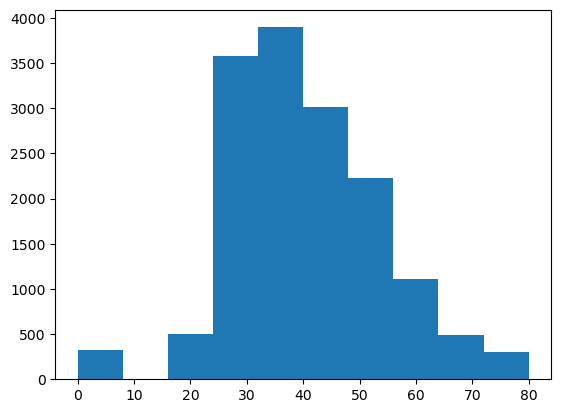

In [7]:
#Covert Age to category after dropping age under under 18
plt.hist(data['Age'])

In [8]:
data.loc[data['Age'] < 18]['Age'].value_counts()

0     320
16      9
17      6
Name: Age, dtype: int64

We need to drop rows with indicies of values 0 as they are incorrect. There are records with age values zero. Its best to drop these and convert age to a range.

In [9]:
indicies = data.loc[data['Age'] == 0].index
#print(indicies)
#print(indicies.shape)

In [10]:
data = data.drop(labels=indicies)
print(data.shape)
#data.head()

(15100, 25)


In [11]:
AgeLabels = ['16-17','18-20','21-25','26-30','31-35','36-40','41-50','51-65','65-100']

#print(len(AgeLabels))

AgeBins =  [16,18,21,26,31,36,41,51,65,100]

#print(len(AgeBins))

AgeCategories = pd.cut(data['Age'], bins = AgeBins,labels=AgeLabels)

In [12]:
data['AgeCategories'] = AgeCategories
data.drop(columns=['Age'],axis=1,inplace=True)

data.columns

Index(['Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed',
       'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfCars',
       'BasePolicy', 'AgeCategories'],
      dtype='object')

In [13]:
#Assign input and output data 
y = data['FraudFound_P']
input_var = [x for x in data.columns if x!='FraudFound_P']
X = data[input_var].astype(str)

In [14]:
#Split data into training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (9060, 24) (9060,)
Test (6040, 24) (6040,)


In [15]:
# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [16]:
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [17]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [18]:
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Feature 0: 5.977216
Feature 1: 1.246565
Feature 2: 1.023801
Feature 3: 1.615413
Feature 4: 0.799405
Feature 5: 1.657577
Feature 6: 0.099326
Feature 7: 112.947257
Feature 8: 40.237777
Feature 9: 71.740590
Feature 10: 93.132556
Feature 11: 0.075305
Feature 12: 0.594966
Feature 13: 1.471831
Feature 14: 0.012558
Feature 15: 0.019329
Feature 16: 1.179073
Feature 17: 2.295835
Feature 18: 2.520005
Feature 19: 0.139524
Feature 20: 6.286047
Feature 21: 1.927466
Feature 22: 130.515945
Feature 23: 4.847505


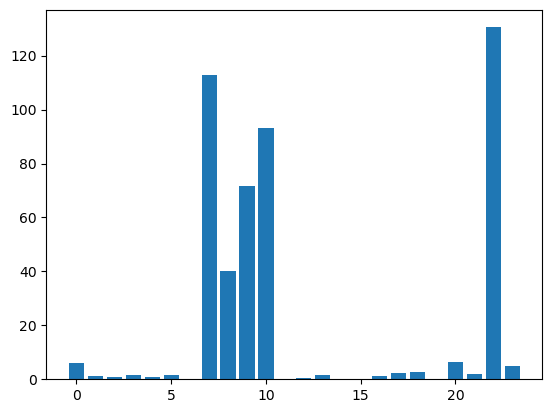

In [19]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [20]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15100 entries, 0 to 15419
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Make                  15100 non-null  object  
 1   AccidentArea          15100 non-null  object  
 2   DayOfWeekClaimed      15100 non-null  object  
 3   MonthClaimed          15100 non-null  object  
 4   WeekOfMonthClaimed    15100 non-null  int64   
 5   Sex                   15100 non-null  object  
 6   MaritalStatus         15100 non-null  object  
 7   Fault                 15100 non-null  object  
 8   PolicyType            15100 non-null  object  
 9   VehicleCategory       15100 non-null  object  
 10  VehiclePrice          15100 non-null  object  
 11  FraudFound_P          15100 non-null  int64   
 12  RepNumber             15100 non-null  int64   
 13  Deductible            15100 non-null  int64   
 14  DriverRating          15100 non-null  int64   
 15  Da

Best features 5 features : 22: NumberOfCars, 7: Fault, 10: VehiclePrice, 9: VehicleCategory, 8: PolicyType

Addional top 5 features: 20: WitnessPresent, 0: Make, 23: BasePolicy , 18:AgeOfVehicle , 17: PastNumberOfClaims

In [21]:
 #train model on top 5 and top 10 to learn accuracy
data_top5 = data[['NumberOfCars', 'Fault', 'VehiclePrice', 'VehicleCategory', 
             'PolicyType']] 

data_top10 = data[['NumberOfCars', 'Fault', 'VehiclePrice', 'VehicleCategory', 'PolicyType',
              'WitnessPresent', 'Make', 'BasePolicy' , 'AgeOfVehicle', 'PastNumberOfClaims']]

In [22]:
#create dummies 
data_top5 = pd.get_dummies(data_top5, drop_first=True)
for feature in data_top5.columns:
    print(feature)

NumberOfCars_2 vehicles
NumberOfCars_3 to 4
NumberOfCars_5 to 8
NumberOfCars_more than 8
Fault_Third Party
VehiclePrice_30000 to 39000
VehiclePrice_40000 to 59000
VehiclePrice_60000 to 69000
VehiclePrice_less than 20000
VehiclePrice_more than 69000
VehicleCategory_Sport
VehicleCategory_Utility
PolicyType_Sedan - Collision
PolicyType_Sedan - Liability
PolicyType_Sport - All Perils
PolicyType_Sport - Collision
PolicyType_Sport - Liability
PolicyType_Utility - All Perils
PolicyType_Utility - Collision
PolicyType_Utility - Liability


In [23]:
data_top5.shape

(15100, 20)

Lets rename our features with white spaces to carry underscores. Example - NumberOfCars_3 to 4 to NumberOfCars_3_to_4.

In [24]:
data_top5.columns = data_top5.columns.str.replace(' ', '_')

for feature in data_top5.columns:
    print(feature)

NumberOfCars_2_vehicles
NumberOfCars_3_to_4
NumberOfCars_5_to_8
NumberOfCars_more_than_8
Fault_Third_Party
VehiclePrice_30000_to_39000
VehiclePrice_40000_to_59000
VehiclePrice_60000_to_69000
VehiclePrice_less_than_20000
VehiclePrice_more_than_69000
VehicleCategory_Sport
VehicleCategory_Utility
PolicyType_Sedan_-_Collision
PolicyType_Sedan_-_Liability
PolicyType_Sport_-_All_Perils
PolicyType_Sport_-_Collision
PolicyType_Sport_-_Liability
PolicyType_Utility_-_All_Perils
PolicyType_Utility_-_Collision
PolicyType_Utility_-_Liability


# Training a basic logistic classifier

In [25]:
X = data_top5
y = data['FraudFound_P']

In [26]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y, train_size=0.6, random_state=15)
BasicLogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression())])
BasicLogitReg.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LogitRegressor', LogisticRegression())])

In [27]:
y_pred = BasicLogitReg.predict(X_train)
classificationSummary(y_train,y_pred)

y_pred_proba = BasicLogitReg.predict_proba(X_train)[::,1]
print(metrics.classification_report(y_train,y_pred))
auc = metrics.roc_auc_score(y_train, y_pred_proba)

print("Area under curve is - ", auc)

Confusion Matrix (Accuracy 0.9440)

       Prediction
Actual    0    1
     0 8553    0
     1  507    0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8553
           1       0.00      0.00      0.00       507

    accuracy                           0.94      9060
   macro avg       0.47      0.50      0.49      9060
weighted avg       0.89      0.94      0.92      9060

Area under curve is -  0.7973311093538815


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
y_pred = BasicLogitReg.predict(X_valid)
classificationSummary(y_pred,y_valid)

y_pred_proba = BasicLogitReg.predict_proba(X_valid)[::,1]
print(metrics.classification_report(y_valid,y_pred))
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print("Area under curve is - ", auc)

Confusion Matrix (Accuracy 0.9363)

       Prediction
Actual    0    1
     0 5655  385
     1    0    0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5655
           1       0.00      0.00      0.00       385

    accuracy                           0.94      6040
   macro avg       0.47      0.50      0.48      6040
weighted avg       0.88      0.94      0.91      6040

Area under curve is -  0.7708124059848197


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
data_top10 = pd.get_dummies(data_top10, drop_first=True)
X = data_top10
y = data['FraudFound_P']

In [30]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y, train_size=0.6, random_state=15)
BasicLogitReg2 = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression())])
BasicLogitReg2.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LogitRegressor', LogisticRegression())])

In [31]:
y_pred2 = BasicLogitReg2.predict(X_valid)
classificationSummary(y_pred2,y_valid)

y_pred_proba2 = BasicLogitReg2.predict_proba(X_valid)[::,1]
print(metrics.classification_report(y_valid,y_pred2))
auc2 = metrics.roc_auc_score(y_valid, y_pred_proba2)

print("Area under curve is - ", auc2)

Confusion Matrix (Accuracy 0.9363)

       Prediction
Actual    0    1
     0 5655  385
     1    0    0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5655
           1       0.00      0.00      0.00       385

    accuracy                           0.94      6040
   macro avg       0.47      0.50      0.48      6040
weighted avg       0.88      0.94      0.91      6040

Area under curve is -  0.7727433486054176


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Our prediction are affected wildy by low sample count. While the samples are very few and the results cannot be trusted. Let try the following sampling methods and various other algorithms -

1. Random under sampling
2. SMOTE - all varieties
3. ADSYN - all varieties

# Random UnderSampler

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.6961)

       Prediction
Actual   0   1
     0 202 160
     1  57 295
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       362
           1       0.65      0.84      0.73       352

    accuracy                           0.70       714
   macro avg       0.71      0.70      0.69       714
weighted avg       0.72      0.70      0.69       714



{'whiskers': [<matplotlib.lines.Line2D at 0x1db4cf8a730>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4cf8acd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4cf8a460>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4cf972b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4cf97580>],
 'means': []}

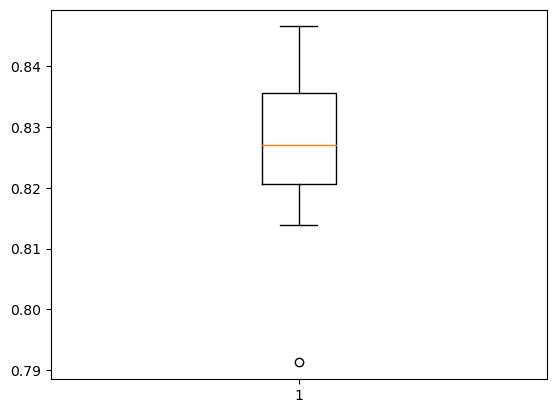

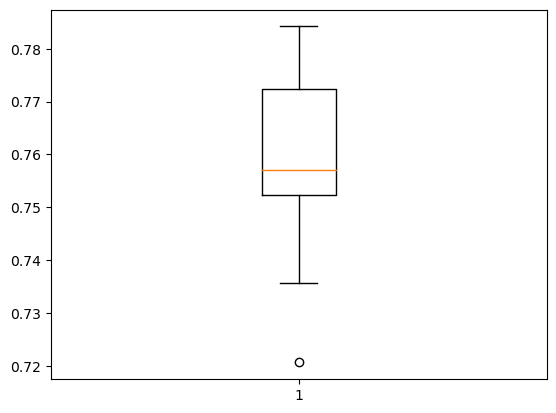

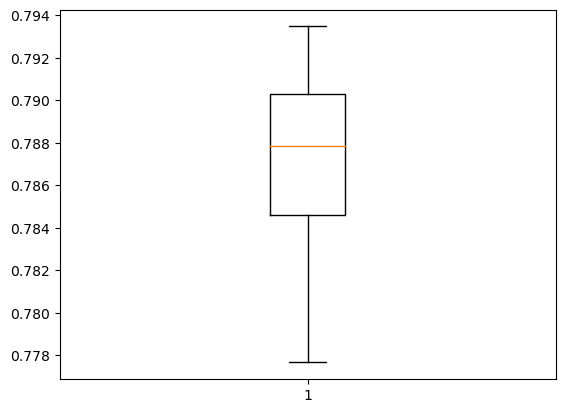

In [32]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

aucTrain_UnderSamplerLogisticRegression = list()
aucValid_UnderSamplerLogisticRegression = list()
aucFullSet_UnderSamplerLogisticRegression = list()

for i in range(1,21):
    UnderSampler = RandomUnderSampler(random_state = i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)


    UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression())])
    UnderSample_LogitReg.fit(X_train,y_train)

    y_pred = UnderSample_LogitReg.predict(X_train)
    
    if i == 1:
        counter = Counter(y_resampled)
        print(counter)
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)
        
        #classificationSummary(y_train,y_pred)
        #print(metrics.classification_report(y_train,y_pred))

        y_pred = UnderSample_LogitReg.predict(X_valid)
        classificationSummary(y_valid,y_pred)
        print(metrics.classification_report(y_valid,y_pred))
    
    y_pred_proba = UnderSample_LogitReg.predict_proba(X_train)[::,1]
    aucTrain_UnderSamplerLogisticRegression.append(metrics.roc_auc_score(y_train, y_pred_proba))
    
    y_pred_proba = UnderSample_LogitReg.predict_proba(X_valid)[::,1]
    aucValid_UnderSamplerLogisticRegression.append(metrics.roc_auc_score(y_valid, y_pred_proba))
    
    y_pred_proba = UnderSample_LogitReg.predict_proba(X)[::,1]
    aucFullSet_UnderSamplerLogisticRegression.append(metrics.roc_auc_score(y, y_pred_proba))

#print("Area under curve is - ", aucTrain)
#print("Area under curve is - ", aucValid)
#print("Area under curve is - ", aucFullSet)

plt.figure()
plt.boxplot(aucTrain_UnderSamplerLogisticRegression)
plt.figure()
plt.boxplot(aucValid_UnderSamplerLogisticRegression)
plt.figure()
plt.boxplot(aucFullSet_UnderSamplerLogisticRegression)

In [120]:
np.mean(aucValid_UnderSamplerLogisticRegression)
fp= open(r'./aucValid_UnderSamplerLogisticRegression.txt', 'w')
fp.write(str(aucValid_UnderSamplerLogisticRegression))
fp.close()

In [33]:
y_pred = UnderSample_LogitReg.predict(X_train)
print(metrics.classification_report(y_train,y_pred))
ClassificationSummary = classificationSummary(y_train,y_pred)
ClassificationSummary

y_pred_proba = UnderSample_LogitReg.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.88      0.59      0.70       530
           1       0.69      0.92      0.79       540

    accuracy                           0.76      1070
   macro avg       0.79      0.75      0.75      1070
weighted avg       0.79      0.76      0.75      1070

Confusion Matrix (Accuracy 0.7551)

       Prediction
Actual   0   1
     0 311 219
     1  43 497
Area under curve is -  0.8208927323549965


In [34]:
y_pred = UnderSample_LogitReg.predict(X_valid)
print(metrics.classification_report(y_valid,y_pred))
ClassificationSummary = classificationSummary(y_valid,y_pred)
ClassificationSummary

y_pred_proba = UnderSample_LogitReg.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.82      0.60      0.70       362
           1       0.68      0.87      0.76       352

    accuracy                           0.73       714
   macro avg       0.75      0.74      0.73       714
weighted avg       0.75      0.73      0.73       714

Confusion Matrix (Accuracy 0.7339)

       Prediction
Actual   0   1
     0 219 143
     1  47 305
Area under curve is -  0.7567373493219488


In [35]:
y_pred = UnderSample_LogitReg.predict(X)

print(metrics.classification_report(y,y_pred))
classificationSummary(y,y_pred)

y_pred_proba = UnderSample_LogitReg.predict_proba(X)[::,1]
auclog_undersample = metrics.roc_auc_score(y, y_pred_proba)

print("Area under curve is - ", auclog_undersample)

              precision    recall  f1-score   support

           0       0.99      0.60      0.75     14208
           1       0.12      0.90      0.22       892

    accuracy                           0.62     15100
   macro avg       0.56      0.75      0.48     15100
weighted avg       0.94      0.62      0.71     15100

Confusion Matrix (Accuracy 0.6159)

       Prediction
Actual    0    1
     0 8498 5710
     1   90  802
Area under curve is -  0.7868756990945542


### Trying decision tree classifier - RandomUnderSampler

In [36]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# single tree
defaultTree = DecisionTreeClassifier(random_state=1)
defaultTree.fit(X_train, y_train)
classes = defaultTree.classes_

y_pred = defaultTree.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= defaultTree.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= defaultTree.predict_proba(X)[::,1]
aucTree_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucTree_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.8935)

       Prediction
Actual   0   1
     0 486  44
     1  70 470
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       530
           1       0.91      0.87      0.89       540

    accuracy                           0.89      1070
   macro avg       0.89      0.89      0.89      1070
weighted avg       0.89      0.89      0.89      1070

Area under curve is -  0.9729577218728162
Confusion Matrix (Accuracy 0.6779)

       Prediction
Actual   0   1
     0 261 101
     1 129 223
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       362
           1       0.69      0.63      0.66       352

    accuracy                           0.68       714
   macro avg       0.68      0.68      0.68       714
weighted avg       0.68      0.68      0.68       714



Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.6569)

       Prediction
Actual   0   1
     0 236 126
     1 119 233
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       362
           1       0.65      0.66      0.66       352

    accuracy                           0.66       714
   macro avg       0.66      0.66      0.66       714
weighted avg       0.66      0.66      0.66       714

Area under curve is -  0.6951908588648918


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4dbc6be0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d8f1790>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d8f1f10>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d9170d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4d9173a0>],
 'means': []}

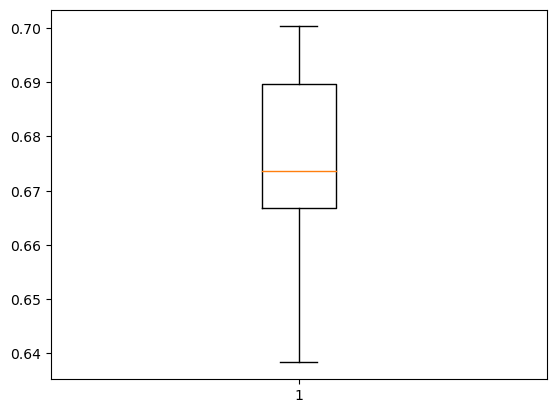

In [37]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_UnderSamplerDefaultTree = list()

for i in range(0,21):
    UnderSampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    defaultTree = DecisionTreeClassifier(random_state=1)
    defaultTree.fit(X_train, y_train)
    classes = defaultTree.classes_


    y_pred = defaultTree.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_UnderSamplerDefaultTree.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_UnderSamplerDefaultTree)    

In [121]:
np.mean(aucValid_UnderSamplerDefaultTree)

fp= open(r'./aucValid_UnderSamplerDefaultTree.txt', 'w')
fp.write(str(aucValid_UnderSamplerDefaultTree))
fp.close()

In [38]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# bagging
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
classes = bagging.classes_

y_pred = bagging.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= bagging.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= bagging.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= bagging.predict_proba(X)[::,1]
aucBag_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBag_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.8972)

       Prediction
Actual   0   1
     0 445  85
     1  25 515
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       530
           1       0.86      0.95      0.90       540

    accuracy                           0.90      1070
   macro avg       0.90      0.90      0.90      1070
weighted avg       0.90      0.90      0.90      1070

Area under curve is -  0.9702900069881202
Confusion Matrix (Accuracy 0.6681)

       Prediction
Actual   0   1
     0 222 140
     1  97 255
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       362
           1       0.65      0.72      0.68       352

    accuracy                           0.67       714
   macro avg       0.67      0.67      0.67       714
weighted avg       0.67      0.67      0.67       714



Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.6891)

       Prediction
Actual   0   1
     0 232 130
     1  92 260
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       362
           1       0.67      0.74      0.70       352

    accuracy                           0.69       714
   macro avg       0.69      0.69      0.69       714
weighted avg       0.69      0.69      0.69       714

Area under curve is -  0.7311730914113511


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d0aeca0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d0a1d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d0ae400>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d0a1d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4d0a30d0>],
 'means': []}

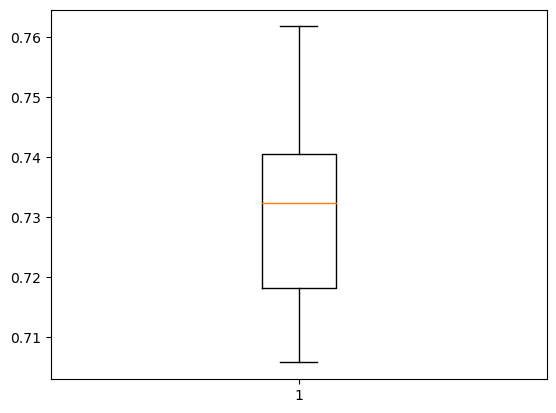

In [39]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_UnderSamplerBagging = list()

for i in range(0,21):
    UnderSampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    bagging.fit(X_train, y_train)
    classes = bagging.classes_


    y_pred = bagging.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= bagging.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_UnderSamplerBagging.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_UnderSamplerBagging)    

In [122]:
np.mean(aucValid_UnderSamplerBagging)

fp= open(r'./aucValid_UnderSamplerBagging.txt', 'w')
fp.write(str(aucValid_UnderSamplerBagging))
fp.close()

In [40]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# boosting
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
boost.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = boost.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= boost.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= boost.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= boost.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.8925)

       Prediction
Actual   0   1
     0 447  83
     1  32 508
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       530
           1       0.86      0.94      0.90       540

    accuracy                           0.89      1070
   macro avg       0.90      0.89      0.89      1070
weighted avg       0.90      0.89      0.89      1070

Area under curve is -  0.9738836477987421
Confusion Matrix (Accuracy 0.6485)

       Prediction
Actual   0   1
     0 229 133
     1 118 234
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       362
           1       0.64      0.66      0.65       352

    accuracy                           0.65       714
   macro avg       0.65      0.65      0.65       714
weighted avg       0.65      0.65      0.65       714



Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.6639)

       Prediction
Actual   0   1
     0 211 151
     1  89 263
              precision    recall  f1-score   support

           0       0.70      0.58      0.64       362
           1       0.64      0.75      0.69       352

    accuracy                           0.66       714
   macro avg       0.67      0.67      0.66       714
weighted avg       0.67      0.66      0.66       714

Area under curve is -  0.7253970994475138


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d342eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d386a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d342430>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d386bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4dd1c670>],
 'means': []}

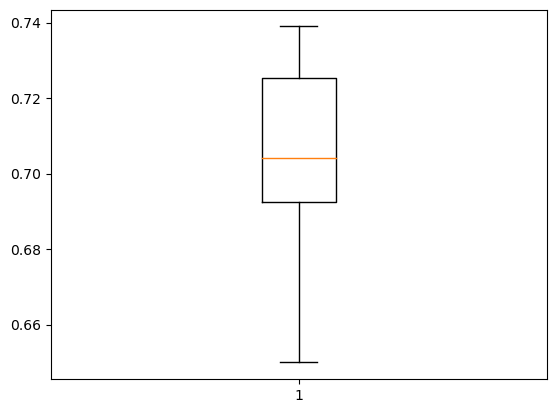

In [41]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_UnderSamplerBoost = list()

for i in range(0,21):
    UnderSampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    boost.fit(X_train, y_train)
    classes = boost.classes_


    y_pred = boost.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= boost.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_UnderSamplerBoost.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_UnderSamplerBoost)    

In [123]:
np.mean(aucValid_UnderSamplerBoost)

fp= open(r'./aucValid_UnderSamplerBoost.txt', 'w')
fp.write(str(aucValid_UnderSamplerBoost))
fp.close()

### KNN with random UnderSampler

In [42]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

k = 5

print("Value of K is - ",k)
#KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= KNN.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = KNN.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= KNN.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", auc)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Value of K is -  5
Confusion Matrix (Accuracy 0.6737)

       Prediction
Actual   0   1
     0 216 146
     1  87 265
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       362
           1       0.64      0.75      0.69       352

    accuracy                           0.67       714
   macro avg       0.68      0.67      0.67       714
weighted avg       0.68      0.67      0.67       714

Area under curve is -  0.7078650803616273


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Confusion Matrix (Accuracy 0.6001)

       Prediction
Actual    0    1
     0 8324 5884
     1  155  737
              precision    recall  f1-score   support

           0       0.98      0.59      0.73     14208
           1       0.11      0.83      0.20       892

    accuracy                           0.60     15100
   macro avg       0.55      0.71      0.47     15100
weighted avg       0.93      0.60      0.70     15100

Area under curve is -  0.7580975427852179


Counter({0: 14208, 1: 892})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.6303)

       Prediction
Actual   0   1
     0 231 131
     1 133 219
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       362
           1       0.63      0.62      0.62       352

    accuracy                           0.63       714
   macro avg       0.63      0.63      0.63       714
weighted avg       0.63      0.63      0.63       714



C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Area under curve is -  0.7253970994475138


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d343ca0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4cfb6040>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4cfc99d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4cfb65e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4cfb68b0>],
 'means': []}

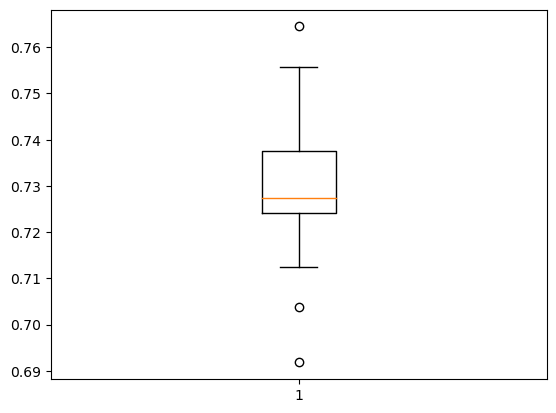

In [43]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_UnderSamplerKNN = list()

for i in range(0,21):
    UnderSampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    k = 5
    
    if k == 1:
        print("Value of K is - ",k)
    #KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
    
    y_pred = KNN.predict(X_valid)
    
    if k == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    if k == 1:
        print("Area under curve is - ", auc)


    y_pred = boost.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= boost.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_UnderSamplerKNN.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_UnderSamplerKNN)    

In [124]:
np.mean(aucValid_UnderSamplerKNN)

fp= open(r'./aucValid_UnderSamplerKNN.txt', 'w')
fp.write(str(aucValid_UnderSamplerKNN))
fp.close()

### SVM with UnderSampling

In [44]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# SVM
SVM = svm.SVC(probability=True)
SVM.fit(X_train, y_train)
classes = SVM.classes_
                      
y_pred = SVM.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba = SVM.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba = SVM.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba = SVM.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.7757)

       Prediction
Actual   0   1
     0 322 208
     1  32 508
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       530
           1       0.71      0.94      0.81       540

    accuracy                           0.78      1070
   macro avg       0.81      0.77      0.77      1070
weighted avg       0.81      0.78      0.77      1070

Area under curve is -  0.9090932914046123
Confusion Matrix (Accuracy 0.7213)

       Prediction
Actual   0   1
     0 202 160
     1  39 313
              precision    recall  f1-score   support

           0       0.84      0.56      0.67       362
           1       0.66      0.89      0.76       352

    accuracy                           0.72       714
   macro avg       0.75      0.72      0.71       714
weighted avg       0.75      0.72      0.71       714



Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.7157)

       Prediction
Actual   0   1
     0 199 163
     1  40 312
              precision    recall  f1-score   support

           0       0.83      0.55      0.66       362
           1       0.66      0.89      0.75       352

    accuracy                           0.72       714
   macro avg       0.74      0.72      0.71       714
weighted avg       0.75      0.72      0.71       714

Area under curve is -  0.7249693935208439


{'whiskers': [<matplotlib.lines.Line2D at 0x1db126d6670>,
 'caps': [<matplotlib.lines.Line2D at 0x1db128581f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db00e7bc10>],
 'medians': [<matplotlib.lines.Line2D at 0x1db12858af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db12858f70>],
 'means': []}

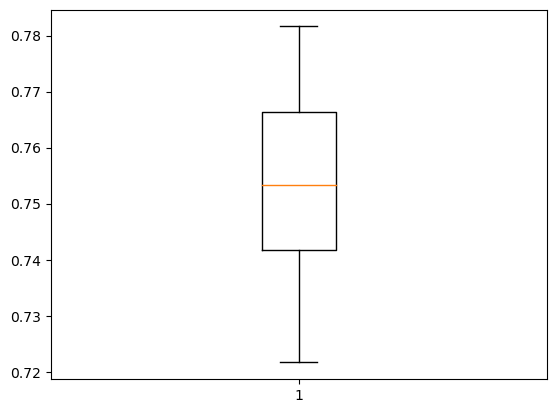

In [125]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

aucSVM_undersample = list()

for i in range(1,21):
    UnderSampler = RandomUnderSampler(random_state=i)
    X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # SVM
    SVM = svm.SVC(probability=True)
    SVM.fit(X_train, y_train)
    classes = SVM.classes_


    y_pred = SVM.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
    
    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
    
    y_pred_proba = SVM.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucSVM_undersample.append(auc)
    
    if i == 1:
        print("Area under curve is - ", auc)
    
plt.figure()
plt.boxplot(aucSVM_undersample)  

In [126]:
np.mean(aucSVM_undersample)

fp= open(r'./aucSVM_undersample.txt', 'w')
fp.write(str(aucSVM_undersample))
fp.close()

# SMOTE Sampling 

In [46]:
# SMOTE Sampling 

X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

SMOTELogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
SMOTELogitReg.fit(X_train,y_train)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


Pipeline(steps=[('scaler', StandardScaler()),
                ('LogitRegressor', LogisticRegression(max_iter=1000))])

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.7516)

       Prediction
Actual    0    1
     0 5551  188
     1 2635 2993
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      5739
           1       0.94      0.53      0.68      5628

    accuracy                           0.75     11367
   macro avg       0.81      0.75      0.74     11367
weighted avg       0.81      0.75      0.74     11367



{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d9dfdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d9eb3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d9dfc40>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d9eb970>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4d9ebc40>],
 'means': []}

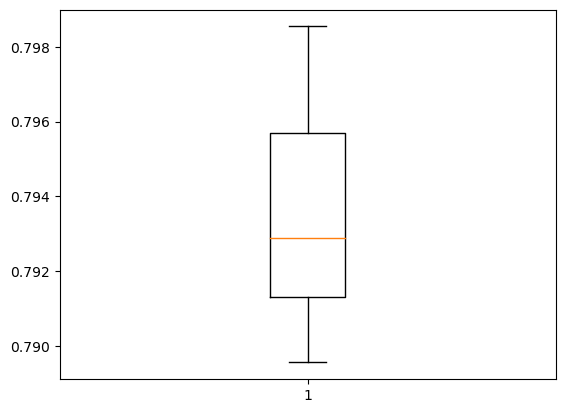

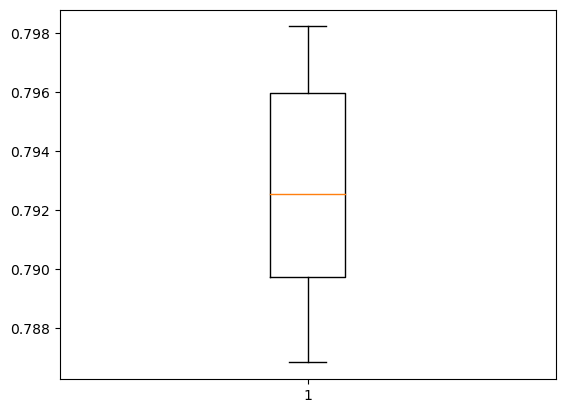

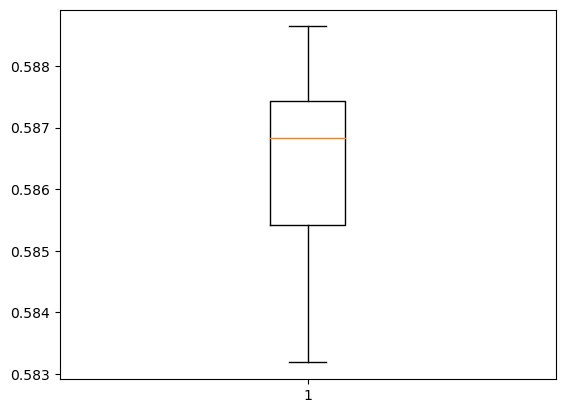

In [47]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

aucTrain_SMOTELogisticRegression = list()
aucValid_SMOTELogisticRegression = list()
aucFullSet_SMOTELogisticRegression = list()

for i in range(1,20):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)


    SMOTE_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
    SMOTE_LogitReg.fit(X_train,y_train)
    
    if i == 1:
        counter = Counter(y_resampled)
        print(counter)
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)
        
        #classificationSummary(y_train,y_pred)
        #print(metrics.classification_report(y_train,y_pred))
    if i == 1:
        y_pred = SMOTE_LogitReg.predict(X_valid)
        classificationSummary(y_valid,y_pred)
        print(metrics.classification_report(y_valid,y_pred))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_train)[::,1]
    aucTrain_SMOTELogisticRegression.append(metrics.roc_auc_score(y_train, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_valid)[::,1]
    aucValid_SMOTELogisticRegression.append(metrics.roc_auc_score(y_valid, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X)[::,1]
    aucFullSet_SMOTELogisticRegression.append(metrics.roc_auc_score(y, y_pred_proba))

#print("Area under curve is - ", aucTrain)
#print("Area under curve is - ", aucValid)
#print("Area under curve is - ", aucFullSet)

plt.figure()
plt.boxplot(aucTrain_SMOTELogisticRegression)
plt.figure()
plt.boxplot(aucValid_SMOTELogisticRegression)
plt.figure()
plt.boxplot(aucFullSet_SMOTELogisticRegression)

In [127]:
np.mean(aucValid_SMOTELogisticRegression)

fp= open(r'./aucValid_SMOTELogisticRegression.txt', 'w')
fp.write(str(aucValid_SMOTELogisticRegression))
fp.close()

## Testing basic logistic classifier with SMOTE

In [48]:
y_pred = SMOTELogitReg.predict(X_train)
print(metrics.classification_report(y_train,y_pred))
classificationSummary(y_train,y_pred)

y_pred_proba = SMOTELogitReg.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.67      0.97      0.79      8469
           1       0.95      0.53      0.68      8580

    accuracy                           0.75     17049
   macro avg       0.81      0.75      0.74     17049
weighted avg       0.81      0.75      0.74     17049

Confusion Matrix (Accuracy 0.7484)

       Prediction
Actual    0    1
     0 8218  251
     1 4039 4541
Area under curve is -  0.7957628135630261


In [49]:
y_pred = SMOTELogitReg.predict(X_valid)
print(metrics.classification_report(y_valid,y_pred))
classificationSummary(y_valid,y_pred)

y_pred_proba = SMOTELogitReg.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      5739
           1       0.95      0.54      0.68      5628

    accuracy                           0.76     11367
   macro avg       0.81      0.75      0.74     11367
weighted avg       0.81      0.76      0.74     11367

Confusion Matrix (Accuracy 0.7554)

       Prediction
Actual    0    1
     0 5575  164
     1 2616 3012
Area under curve is -  0.7947835654327373


In [50]:
y_pred = SMOTELogitReg.predict(X)
print(metrics.classification_report(y,y_pred))
classificationSummary(y,y_pred)

y_pred_proba = SMOTELogitReg.predict_proba(X)[::,1]
auc_smote = metrics.roc_auc_score(y, y_pred_proba)

print("Area under curve is - ", auc_smote)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     14208
           1       0.14      0.07      0.09       892

    accuracy                           0.92     15100
   macro avg       0.54      0.52      0.53     15100
weighted avg       0.90      0.92      0.91     15100

Confusion Matrix (Accuracy 0.9177)

       Prediction
Actual     0     1
     0 13793   415
     1   827    65
Area under curve is -  0.5849830307816224


## Testing with trees - SMOTE

In [51]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# single tree
defaultTree = DecisionTreeClassifier(random_state=1)
defaultTree.fit(X_train, y_train)
classes = defaultTree.classes_

y_pred = defaultTree.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= defaultTree.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= defaultTree.predict_proba(X)[::,1]
aucTree_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucTree_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8965)

       Prediction
Actual    0    1
     0 7274 1195
     1  569 8011
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      8469
           1       0.87      0.93      0.90      8580

    accuracy                           0.90     17049
   macro avg       0.90      0.90      0.90     17049
weighted avg       0.90      0.90      0.90     17049

Area under curve is -  0.9682815305291393
Confusion Matrix (Accuracy 0.8727)

       Prediction
Actual    0    1
     0 4801  938
     1  509 5119
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5739
           1       0.85      0.91      0.88      5628

    accuracy                           0.87     11367
   macro avg       0.87      0.87      0.87     11367
weighted avg       0.87      0.87  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8691)

       Prediction
Actual    0    1
     0 4772  967
     1  521 5107
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      5739
           1       0.84      0.91      0.87      5628

    accuracy                           0.87     11367
   macro avg       0.87      0.87      0.87     11367
weighted avg       0.87      0.87      0.87     11367

Area under curve is -  0.9417944318682394


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4da012b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4da01d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4da01040>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d9ab700>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4d9ab880>],
 'means': []}

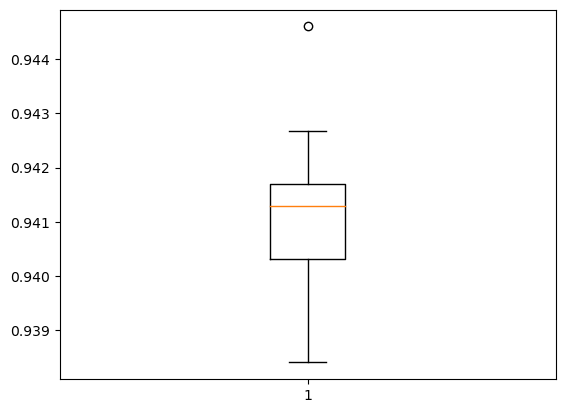

In [52]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SMOTE_DefaultTree = list()

for i in range(0,21):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    defaultTree = DecisionTreeClassifier(random_state=1)
    defaultTree.fit(X_train, y_train)
    classes = defaultTree.classes_


    y_pred = defaultTree.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SMOTE_DefaultTree.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SMOTE_DefaultTree)    

In [128]:
np.mean(aucValid_SMOTE_DefaultTree)

fp= open(r'./aucValid_SMOTE_DefaultTree.txt', 'w')
fp.write(str(aucValid_SMOTE_DefaultTree))
fp.close()

In [53]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# bagging
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
classes = bagging.classes_

y_pred = bagging.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= bagging.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= bagging.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= bagging.predict_proba(X)[::,1]
aucBag_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBag_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8937)

       Prediction
Actual    0    1
     0 7137 1332
     1  480 8100
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      8469
           1       0.86      0.94      0.90      8580

    accuracy                           0.89     17049
   macro avg       0.90      0.89      0.89     17049
weighted avg       0.90      0.89      0.89     17049

Area under curve is -  0.9659240432885493
Confusion Matrix (Accuracy 0.8744)

       Prediction
Actual    0    1
     0 4733 1006
     1  422 5206
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      5739
           1       0.84      0.93      0.88      5628

    accuracy                           0.87     11367
   macro avg       0.88      0.87      0.87     11367
weighted avg       0.88      0.87  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8762)

       Prediction
Actual    0    1
     0 4788  951
     1  456 5172
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      5739
           1       0.84      0.92      0.88      5628

    accuracy                           0.88     11367
   macro avg       0.88      0.88      0.88     11367
weighted avg       0.88      0.88      0.88     11367

Area under curve is -  0.951682759379118


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d983160>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d950760>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d983fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d950d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4d950a90>],
 'means': []}

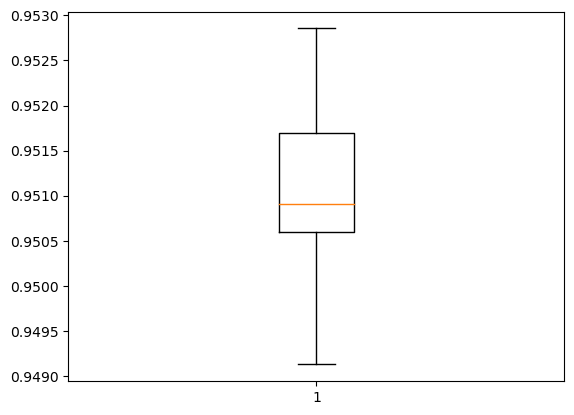

In [54]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SMOTEBagging = list()

for i in range(1,21):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    bagging.fit(X_train, y_train)
    classes = bagging.classes_


    y_pred = bagging.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= bagging.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SMOTEBagging.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SMOTEBagging)    

In [129]:
np.mean(aucValid_SMOTEBagging)

fp= open(r'./aucValid_SMOTEBagging.txt', 'w')
fp.write(str(aucValid_SMOTEBagging))
fp.close()

In [55]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# boosting
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
boost.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = boost.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= boost.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= boost.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= boost.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8955)

       Prediction
Actual    0    1
     0 7251 1218
     1  563 8017
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      8469
           1       0.87      0.93      0.90      8580

    accuracy                           0.90     17049
   macro avg       0.90      0.90      0.90     17049
weighted avg       0.90      0.90      0.90     17049

Area under curve is -  0.9686310570210677
Confusion Matrix (Accuracy 0.8795)

       Prediction
Actual    0    1
     0 4859  880
     1  490 5138
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5739
           1       0.85      0.91      0.88      5628

    accuracy                           0.88     11367
   macro avg       0.88      0.88      0.88     11367
weighted avg       0.88      0.88  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8802)

       Prediction
Actual    0    1
     0 4785  954
     1  408 5220
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      5739
           1       0.85      0.93      0.88      5628

    accuracy                           0.88     11367
   macro avg       0.88      0.88      0.88     11367
weighted avg       0.88      0.88      0.88     11367

Area under curve is -  0.9507536001321647


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4d970580>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4d970700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4d952f40>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4d9707f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4dc31220>],
 'means': []}

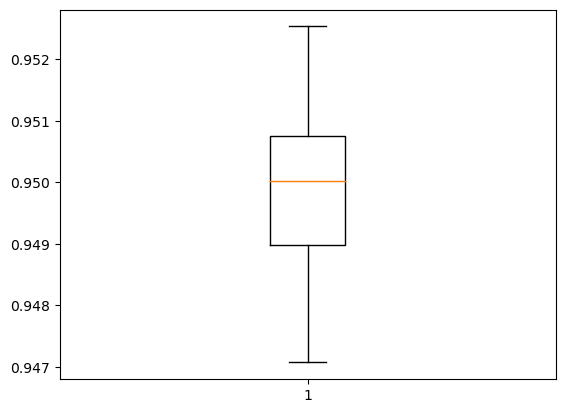

In [56]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SMOTEBoost = list()

for i in range(0,21):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    boost.fit(X_train, y_train)
    classes = boost.classes_


    y_pred = boost.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= boost.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SMOTEBoost.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SMOTEBoost)    

In [130]:
np.mean(aucValid_SMOTEBoost)

fp= open(r'./aucValid_SMOTEBoost.txt', 'w')
fp.write(str(aucValid_SMOTEBoost))
fp.close()

## Testing with KNN - simple SMOTE

In [57]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

k = 5
print("Value of K is - ",k)
#KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= KNN.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = KNN.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= KNN.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", auc)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Value of K is -  5


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8488)

       Prediction
Actual    0    1
     0 4674 1065
     1  654 4974
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      5739
           1       0.82      0.88      0.85      5628

    accuracy                           0.85     11367
   macro avg       0.85      0.85      0.85     11367
weighted avg       0.85      0.85      0.85     11367

Area under curve is -  0.9279778824742195


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8129)

       Prediction
Actual     0     1
     0 11719  2489
     1   336   556
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     14208
           1       0.18      0.62      0.28       892

    accuracy                           0.81     15100
   macro avg       0.58      0.72      0.59     15100
weighted avg       0.93      0.81      0.86     15100

Area under curve is -  0.823894609996768


Counter({0: 14208, 1: 892})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Confusion Matrix (Accuracy 0.8561)

       Prediction
Actual    0    1
     0 4667 1072
     1  564 5064
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      5739
           1       0.83      0.90      0.86      5628

    accuracy                           0.86     11367
   macro avg       0.86      0.86      0.86     11367
weighted avg       0.86      0.86      0.86     11367



C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Area under curve is -  0.9284076004365697


{'whiskers': [<matplotlib.lines.Line2D at 0x1db4da416d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db4da4bdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4da4bb20>],
 'medians': [<matplotlib.lines.Line2D at 0x1db4da4bb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db4da6a2e0>],
 'means': []}

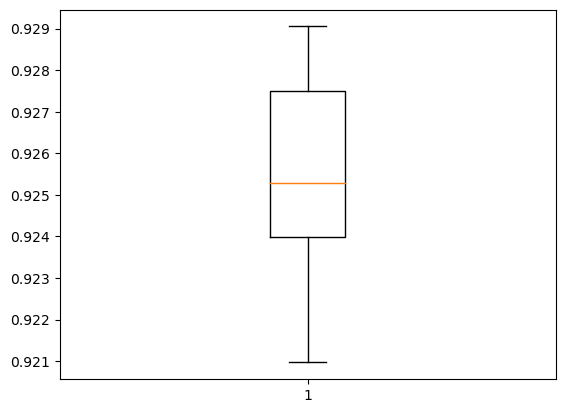

In [58]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SMOTEKNN = list()

for i in range(0,21):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    k = 5
    
    if k == 1:
        print("Value of K is - ",k)
    #KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
    
    y_pred = KNN.predict(X_valid)
    
    if k == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    if k == 1:
        print("Area under curve is - ", auc)


    y_pred = KNN.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SMOTEKNN.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SMOTEKNN)    

In [131]:
np.mean(aucValid_SMOTEKNN)

fp= open(r'./aucValid_SMOTEKNN.txt', 'w')
fp.write(str(aucValid_SMOTEKNN))
fp.close()

In [59]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSampler = RandomUnderSampler()
X_resampled, y_resampled = UnderSampler.fit_resample(X, y)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# SVM
SVM = svm.SVC(probability=True)
SVM.fit(X_train, y_train)
classes = SVM.classes_
                      
y_pred = SVM.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba = SVM.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba = SVM.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba = SVM.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 892, 1: 892})
Counter({1: 540, 0: 530})
Counter({0: 362, 1: 352})
Confusion Matrix (Accuracy 0.7813)

       Prediction
Actual   0   1
     0 328 202
     1  32 508
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       530
           1       0.72      0.94      0.81       540

    accuracy                           0.78      1070
   macro avg       0.81      0.78      0.77      1070
weighted avg       0.81      0.78      0.78      1070

Area under curve is -  0.8971872816212438
Confusion Matrix (Accuracy 0.7507)

       Prediction
Actual   0   1
     0 223 139
     1  39 313
              precision    recall  f1-score   support

           0       0.85      0.62      0.71       362
           1       0.69      0.89      0.78       352

    accuracy                           0.75       714
   macro avg       0.77      0.75      0.75       714
weighted avg       0.77      0.75      0.75       714



Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.7363)

       Prediction
Actual    0    1
     0 5739    0
     1 2997 2631
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      5739
           1       1.00      0.47      0.64      5628

    accuracy                           0.74     11367
   macro avg       0.83      0.73      0.72     11367
weighted avg       0.83      0.74      0.72     11367

Area under curve is -  0.8870821817529732


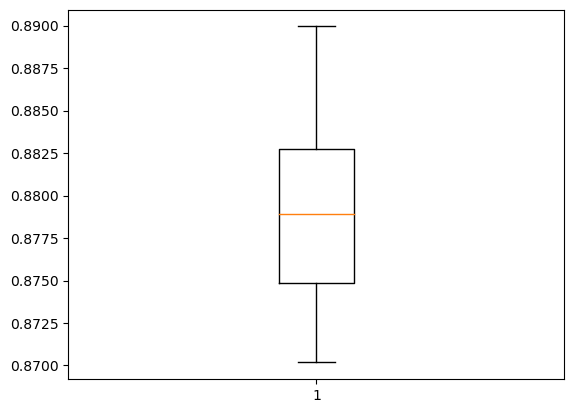

In [60]:
if RunSVM:    
    X = data_top10
    y = data['FraudFound_P']

    counter = Counter(y)
    print(counter)

    aucSVM_SMOTE = list()

    for i in range(1,21):
        over = SMOTE(random_state=i)
        under = RandomUnderSampler(sampling_strategy=1)
        steps = [('o', over), ('u', under)]
        SMOTESampling = SamplingPipeline(steps=steps)
        X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

        if i == 1:
            counter = Counter(y_resampled)
            print(counter)

        X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

        if i == 1:
            counter = Counter(y_train)
            print(counter)
            counter = Counter(y_valid)
            print(counter)

        # SVM
        SVM = svm.SVC(probability=True)
        SVM.fit(X_train, y_train)
        classes = SVM.classes_


        y_pred = SVM.predict(X_valid)

        if i == 1:
            classificationSummary(y_valid, y_pred, class_names=classes)

        if i == 1:
            print(metrics.classification_report(y_valid,y_pred))

        y_pred_proba = SVM.predict_proba(X_valid)[::,1]
        auc = metrics.roc_auc_score(y_valid,y_pred_proba)
        aucSVM_SMOTE.append(auc)

        if i == 1:
            print("Area under curve is - ", auc)

    plt.figure()
    plt.boxplot(aucSVM_SMOTE)  

In [132]:
print(np.mean(aucSVM_SMOTE))

fp= open(r'./aucSVM_SMOTE.txt', 'w')
fp.write(str(aucSVM_SMOTE))
fp.close()

0.8793931722600747


# Borderline SMOTE

### Logistic regression with Borderline SMOTE

In [61]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

BorderlineSMOTE_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
BorderlineSMOTE_LogitReg.fit(X_train,y_train)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


Pipeline(steps=[('scaler', StandardScaler()),
                ('LogitRegressor', LogisticRegression(max_iter=1000))])

## Results with borderline sampling

In [62]:
y_pred = BorderlineSMOTE_LogitReg.predict(X_train)
print(metrics.classification_report(y_train,y_pred))
classificationSummary(y_train,y_pred)

y_pred_proba = BorderlineSMOTE_LogitReg.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.67      0.97      0.79      8469
           1       0.95      0.52      0.67      8580

    accuracy                           0.74     17049
   macro avg       0.81      0.75      0.73     17049
weighted avg       0.81      0.74      0.73     17049

Confusion Matrix (Accuracy 0.7442)

       Prediction
Actual    0    1
     0 8230  239
     1 4122 4458
Area under curve is -  0.7817079484454619


In [63]:
y_pred = BorderlineSMOTE_LogitReg.predict(X_valid)
print(metrics.classification_report(y_valid,y_pred))
classificationSummary(y_valid,y_pred)

y_pred_proba = BorderlineSMOTE_LogitReg.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.67      0.97      0.79      5739
           1       0.94      0.52      0.67      5628

    accuracy                           0.75     11367
   macro avg       0.81      0.74      0.73     11367
weighted avg       0.81      0.75      0.73     11367

Confusion Matrix (Accuracy 0.7453)

       Prediction
Actual    0    1
     0 5567  172
     1 2723 2905
Area under curve is -  0.7757579686760235


In [64]:
y_pred = BorderlineSMOTE_LogitReg.predict(X)
print(metrics.classification_report(y,y_pred))
classificationSummary(y,y_pred)

y_pred_proba = BorderlineSMOTE_LogitReg.predict_proba(X)[::,1]
auc_borderlineSMOTE = metrics.roc_auc_score(y, y_pred_proba)

print("Area under curve is - ", auc_borderlineSMOTE)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     14208
           1       0.13      0.07      0.09       892

    accuracy                           0.92     15100
   macro avg       0.54      0.52      0.52     15100
weighted avg       0.90      0.92      0.91     15100

Confusion Matrix (Accuracy 0.9177)

       Prediction
Actual     0     1
     0 13797   411
     1   831    61
Area under curve is -  0.5852087767770573


Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.7463)

       Prediction
Actual    0    1
     0 5584  155
     1 2729 2899
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      5739
           1       0.95      0.52      0.67      5628

    accuracy                           0.75     11367
   macro avg       0.81      0.74      0.73     11367
weighted avg       0.81      0.75      0.73     11367



{'whiskers': [<matplotlib.lines.Line2D at 0x1db004b2280>,
 'caps': [<matplotlib.lines.Line2D at 0x1db004b2820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db004a6f70>],
 'medians': [<matplotlib.lines.Line2D at 0x1db004b2dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db004bb0d0>],
 'means': []}

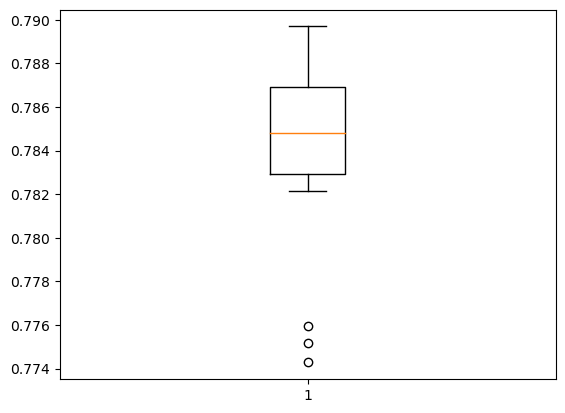

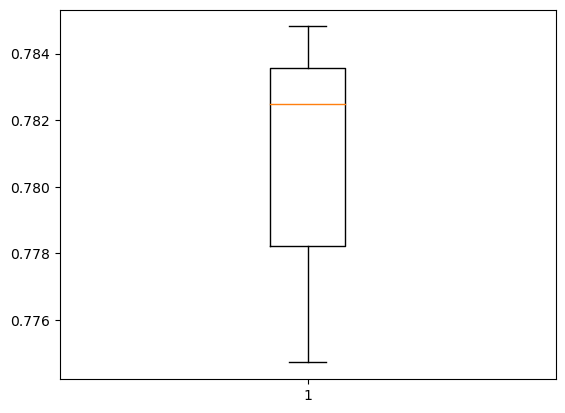

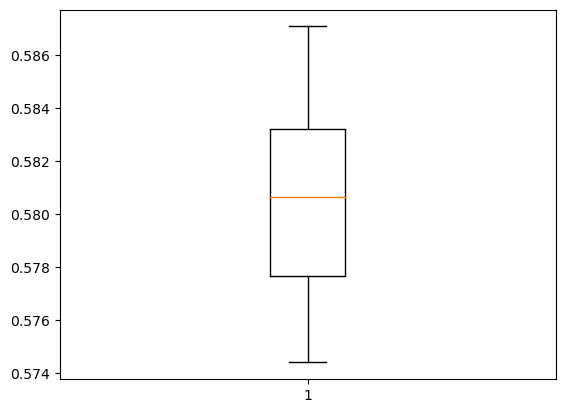

In [65]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

aucTrain_BorderSMOTELogisticRegression = list()
aucValid_BorderSMOTELogisticRegression = list()
aucFullSet_BorderSMOTELogisticRegression = list()

for i in range(1,21):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)


    SMOTE_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
    SMOTE_LogitReg.fit(X_train,y_train)
    
    if i == 1:
        counter = Counter(y_resampled)
        print(counter)
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)
        
        #classificationSummary(y_train,y_pred)
        #print(metrics.classification_report(y_train,y_pred))
    if i == 1:
        y_pred = SMOTE_LogitReg.predict(X_valid)
        classificationSummary(y_valid,y_pred)
        print(metrics.classification_report(y_valid,y_pred))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_train)[::,1]
    aucTrain_BorderSMOTELogisticRegression.append(metrics.roc_auc_score(y_train, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_valid)[::,1]
    aucValid_BorderSMOTELogisticRegression.append(metrics.roc_auc_score(y_valid, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X)[::,1]
    aucFullSet_BorderSMOTELogisticRegression.append(metrics.roc_auc_score(y, y_pred_proba))

#print("Area under curve is - ", aucTrain)
#print("Area under curve is - ", aucValid)
#print("Area under curve is - ", aucFullSet)

plt.figure()
plt.boxplot(aucTrain_BorderSMOTELogisticRegression)
plt.figure()
plt.boxplot(aucValid_BorderSMOTELogisticRegression)
plt.figure()
plt.boxplot(aucFullSet_BorderSMOTELogisticRegression)

In [133]:
fp= open(r'./aucValid_BorderSMOTELogisticRegression.txt', 'w')
fp.write(str(aucValid_BorderSMOTELogisticRegression))
fp.close()

np.mean(aucValid_BorderSMOTELogisticRegression)

0.7807990407284515

### Testing with tree - borderline SMOTE

In [66]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# default-tree
defaultTree = DecisionTreeClassifier(random_state=1)
defaultTree.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = defaultTree.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= defaultTree.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= defaultTree.predict_proba(X)[::,1]
aucBag_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBag_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9141)

       Prediction
Actual    0    1
     0 7351 1118
     1  346 8234
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8469
           1       0.88      0.96      0.92      8580

    accuracy                           0.91     17049
   macro avg       0.92      0.91      0.91     17049
weighted avg       0.92      0.91      0.91     17049

Area under curve is -  0.9742007185949801
Confusion Matrix (Accuracy 0.8934)

       Prediction
Actual    0    1
     0 4845  894
     1  318 5310
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      5739
           1       0.86      0.94      0.90      5628

    accuracy                           0.89     11367
   macro avg       0.90      0.89      0.89     11367
weighted avg       0.90      0.89  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8920)

       Prediction
Actual    0    1
     0 4873  866
     1  362 5266
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      5739
           1       0.86      0.94      0.90      5628

    accuracy                           0.89     11367
   macro avg       0.89      0.89      0.89     11367
weighted avg       0.90      0.89      0.89     11367

Area under curve is -  0.9493432973286059


{'whiskers': [<matplotlib.lines.Line2D at 0x1db0003ffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db0003b2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db00035d90>],
 'medians': [<matplotlib.lines.Line2D at 0x1db0003bd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db006551f0>],
 'means': []}

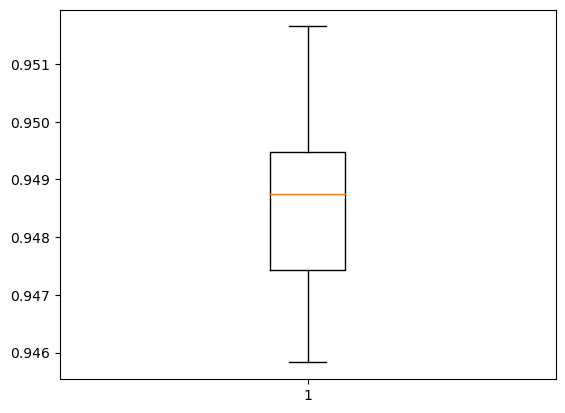

In [67]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_BorderSMOTE_DefaultTree = list()

for i in range(0,21):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    defaultTree = DecisionTreeClassifier(random_state=1)
    defaultTree.fit(X_train, y_train)
    classes = defaultTree.classes_


    y_pred = defaultTree.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_BorderSMOTE_DefaultTree.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_BorderSMOTE_DefaultTree)    

In [134]:
fp= open(r'./aucValid_BorderSMOTE_DefaultTree.txt', 'w')
fp.write(str(aucValid_BorderSMOTE_DefaultTree))
fp.close()


np.mean(aucValid_BorderSMOTE_DefaultTree)

0.9486234525313177

In [68]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# boosting
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = bagging.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= bagging.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= bagging.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= bagging.predict_proba(X)[::,1]
aucBag_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBag_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8588)

       Prediction
Actual    0    1
     0 6226 2243
     1  165 8415
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      8469
           1       0.79      0.98      0.87      8580

    accuracy                           0.86     17049
   macro avg       0.88      0.86      0.86     17049
weighted avg       0.88      0.86      0.86     17049

Area under curve is -  0.8897818273748136
Confusion Matrix (Accuracy 0.8563)

       Prediction
Actual    0    1
     0 4250 1489
     1  145 5483
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5739
           1       0.79      0.97      0.87      5628

    accuracy                           0.86     11367
   macro avg       0.88      0.86      0.85     11367
weighted avg       0.88      0.86  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8941)

       Prediction
Actual    0    1
     0 4857  882
     1  322 5306
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      5739
           1       0.86      0.94      0.90      5628

    accuracy                           0.89     11367
   macro avg       0.90      0.89      0.89     11367
weighted avg       0.90      0.89      0.89     11367

Area under curve is -  0.958074456086877


{'whiskers': [<matplotlib.lines.Line2D at 0x1db004cb8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db004cb130>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db004cb310>],
 'medians': [<matplotlib.lines.Line2D at 0x1db004e94c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db004e9790>],
 'means': []}

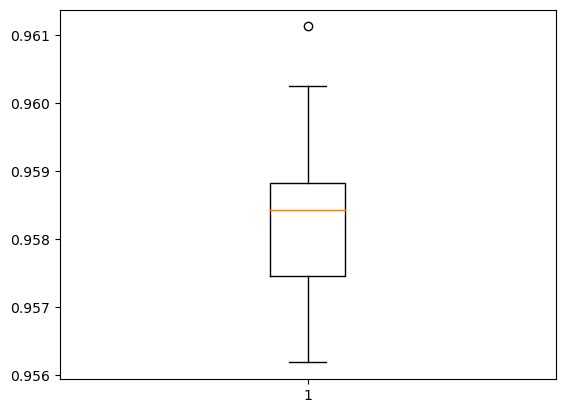

In [69]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_BorderSMOTEBagging = list()

for i in range(1,21):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    bagging.fit(X_train, y_train)
    classes = bagging.classes_


    y_pred = bagging.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= bagging.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_BorderSMOTEBagging.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_BorderSMOTEBagging)    

In [136]:
fp= open(r'./aucValid_BorderSMOTEBagging.txt', 'w')
fp.write(str(aucValid_BorderSMOTEBagging))
fp.close()

np.mean(aucValid_BorderSMOTEBagging)

0.9583403134057142

In [70]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# boosting
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
boost.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = boost.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= boost.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= boost.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= boost.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9147)

       Prediction
Actual    0    1
     0 7311 1158
     1  296 8284
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      8469
           1       0.88      0.97      0.92      8580

    accuracy                           0.91     17049
   macro avg       0.92      0.91      0.91     17049
weighted avg       0.92      0.91      0.91     17049

Area under curve is -  0.974700044120873
Confusion Matrix (Accuracy 0.9002)

       Prediction
Actual    0    1
     0 4890  849
     1  285 5343
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      5739
           1       0.86      0.95      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90   

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8960)

       Prediction
Actual    0    1
     0 4871  868
     1  314 5314
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      5739
           1       0.86      0.94      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90      0.90     11367

Area under curve is -  0.9584122209998969


{'whiskers': [<matplotlib.lines.Line2D at 0x1db00504eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db0052f490>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db00504340>],
 'medians': [<matplotlib.lines.Line2D at 0x1db0052fa30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db0052fd00>],
 'means': []}

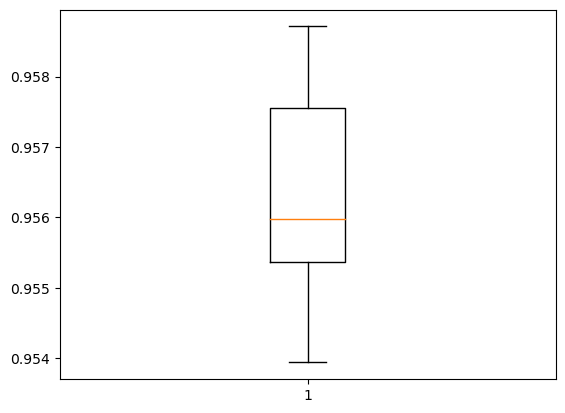

In [71]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_BorderLineSMOTEBoost = list()

for i in range(0,21):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    boost.fit(X_train, y_train)
    classes = boost.classes_


    y_pred = boost.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= boost.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_BorderLineSMOTEBoost.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_BorderLineSMOTEBoost)    

In [137]:
fp= open(r'./aucValid_BorderLineSMOTEBoost.txt', 'w')
fp.write(str(aucValid_BorderLineSMOTEBoost))
fp.close()


np.mean(aucValid_BorderLineSMOTEBoost)

0.9563986062341495

### Testing with KNN - borderline SMOTE

In [72]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

k = 5
print("Value of K is - ",k)
#KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)

y_pred = KNN.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= KNN.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = KNN.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= KNN.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", auc)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Value of K is -  5


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8804)

       Prediction
Actual    0    1
     0 4719 1020
     1  340 5288
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5739
           1       0.84      0.94      0.89      5628

    accuracy                           0.88     11367
   macro avg       0.89      0.88      0.88     11367
weighted avg       0.89      0.88      0.88     11367

Area under curve is -  0.9336472059338388


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8204)

       Prediction
Actual     0     1
     0 11837  2371
     1   341   551
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     14208
           1       0.19      0.62      0.29       892

    accuracy                           0.82     15100
   macro avg       0.58      0.73      0.59     15100
weighted avg       0.93      0.82      0.86     15100

Area under curve is -  0.806796579896881


Counter({0: 14208, 1: 892})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Confusion Matrix (Accuracy 0.8747)

       Prediction
Actual    0    1
     0 4806  933
     1  491 5137
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5739
           1       0.85      0.91      0.88      5628

    accuracy                           0.87     11367
   macro avg       0.88      0.88      0.87     11367
weighted avg       0.88      0.87      0.87     11367



C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Area under curve is -  0.9367421226578133


{'whiskers': [<matplotlib.lines.Line2D at 0x1db0056a640>,
 'caps': [<matplotlib.lines.Line2D at 0x1db0057d040>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db005718e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1db0057d5e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db0057d8b0>],
 'means': []}

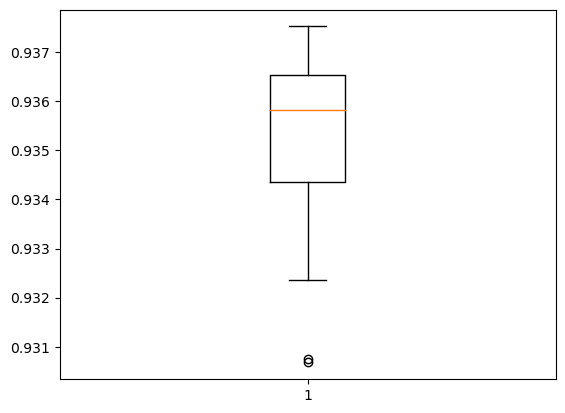

In [73]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_BorderSMOTEKNN = list()

for i in range(0,21):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    k = 5
    
    if k == 1:
        print("Value of K is - ",k)
    #KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
    
    y_pred = KNN.predict(X_valid)
    
    if k == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    if k == 1:
        print("Area under curve is - ", auc)


    y_pred = KNN.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_BorderSMOTEKNN.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_BorderSMOTEKNN)    

In [138]:
fp= open(r'./aucValid_BorderSMOTEKNN.txt', 'w')
fp.write(str(aucValid_BorderSMOTEKNN))
fp.close()


np.mean(aucValid_BorderSMOTEKNN)

0.9351059392599881

### Borderline SMOTE with SVM

In [74]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = BorderlineSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# SVM
SVM = svm.SVC(probability=True)
SVM.fit(X_train, y_train)
classes = SVM.classes_
                      
y_pred = SVM.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba = SVM.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba = SVM.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba = SVM.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.7329)

       Prediction
Actual    0    1
     0 8469    0
     1 4553 4027
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      8469
           1       1.00      0.47      0.64      8580

    accuracy                           0.73     17049
   macro avg       0.83      0.73      0.71     17049
weighted avg       0.83      0.73      0.71     17049

Area under curve is -  0.8890308573624195
Confusion Matrix (Accuracy 0.7304)

       Prediction
Actual    0    1
     0 5739    0
     1 3065 2563
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      5739
           1       1.00      0.46      0.63      5628

    accuracy                           0.73     11367
   macro avg       0.83      0.73      0.71     11367
weighted avg       0.82      0.73  

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Area under curve is -  0.7602340420226842


Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.7269)

       Prediction
Actual    0    1
     0 5739    0
     1 3104 2524
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      5739
           1       1.00      0.45      0.62      5628

    accuracy                           0.73     11367
   macro avg       0.82      0.72      0.70     11367
weighted avg       0.82      0.73      0.70     11367

Area under curve is -  0.8854379250042075


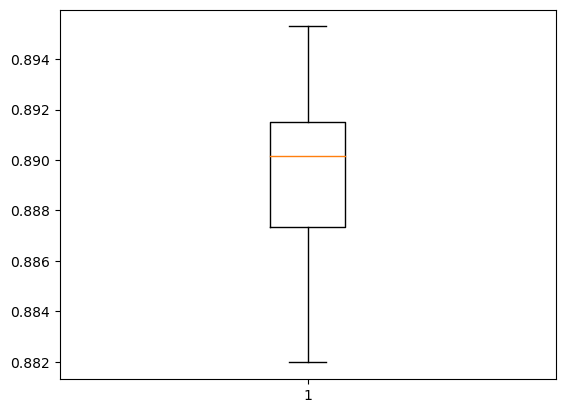

In [75]:
if RunSVM:    
    X = data_top10
    y = data['FraudFound_P']

    counter = Counter(y)
    print(counter)

    aucSVM_BorderlineSMOTE = list()

    for i in range(1,21):
        over = BorderlineSMOTE(random_state=i)
        under = RandomUnderSampler(sampling_strategy=1)
        steps = [('o', over), ('u', under)]
        SMOTESampling = SamplingPipeline(steps=steps)
        X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

        if i == 1:
            counter = Counter(y_resampled)
            print(counter)

        X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

        if i == 1:
            counter = Counter(y_train)
            print(counter)
            counter = Counter(y_valid)
            print(counter)

        # SVM
        SVM = svm.SVC(probability=True)
        SVM.fit(X_train, y_train)
        classes = SVM.classes_


        y_pred = SVM.predict(X_valid)

        if i == 1:
            classificationSummary(y_valid, y_pred, class_names=classes)

        if i == 1:
            print(metrics.classification_report(y_valid,y_pred))

        y_pred_proba = SVM.predict_proba(X_valid)[::,1]
        auc = metrics.roc_auc_score(y_valid,y_pred_proba)
        aucSVM_BorderlineSMOTE.append(auc)

        if i == 1:
            print("Area under curve is - ", auc)

    plt.figure()
    plt.boxplot(aucSVM_BorderlineSMOTE)  

In [139]:
fp= open(r'./aucSVM_BorderlineSMOTE.txt', 'w')
fp.write(str(aucSVM_BorderlineSMOTE))
fp.close()


np.mean(aucSVM_BorderlineSMOTE)

0.8893576249759592

# Results with SVM SMOTE

### Basic logistic regression with SMOTESVM

In [76]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

SMOTESVM_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
SMOTESVM_LogitReg.fit(X_train,y_train)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


Pipeline(steps=[('scaler', StandardScaler()),
                ('LogitRegressor', LogisticRegression(max_iter=1000))])

In [77]:
y_pred = SMOTESVM_LogitReg.predict(X_train)
print(metrics.classification_report(y_train,y_pred))
classificationSummary(y_train,y_pred)

y_pred_proba = SMOTESVM_LogitReg.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      8469
           1       0.98      0.74      0.84      8580

    accuracy                           0.86     17049
   macro avg       0.88      0.86      0.86     17049
weighted avg       0.89      0.86      0.86     17049

Confusion Matrix (Accuracy 0.8609)

       Prediction
Actual    0    1
     0 8357  112
     1 2260 6320
Area under curve is -  0.8873413416984087


In [78]:
y_pred = SMOTESVM_LogitReg.predict(X_valid)
print(metrics.classification_report(y_valid,y_pred))
classificationSummary(y_valid,y_pred)

y_pred_proba = SMOTESVM_LogitReg.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

print("Area under curve is - ", auc)

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      5739
           1       0.98      0.72      0.83      5628

    accuracy                           0.86     11367
   macro avg       0.88      0.86      0.85     11367
weighted avg       0.88      0.86      0.85     11367

Confusion Matrix (Accuracy 0.8570)

       Prediction
Actual    0    1
     0 5666   73
     1 1553 4075
Area under curve is -  0.8777889793310597


In [79]:
y_pred = SMOTESVM_LogitReg.predict(X)
print(metrics.classification_report(y,y_pred))
classificationSummary(y,y_pred)

y_pred_proba = SMOTESVM_LogitReg.predict_proba(X)[::,1]
auc_SVMSmote = metrics.roc_auc_score(y, y_pred_proba)

print("Area under curve is - ", auc_SVMSmote)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     14208
           1       0.16      0.04      0.06       892

    accuracy                           0.93     15100
   macro avg       0.55      0.51      0.51     15100
weighted avg       0.90      0.93      0.91     15100

Confusion Matrix (Accuracy 0.9311)

       Prediction
Actual     0     1
     0 14023   185
     1   856    36
Area under curve is -  0.5790697639553791


Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8126)

       Prediction
Actual    0    1
     0 5615  124
     1 2006 3622
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      5739
           1       0.97      0.64      0.77      5628

    accuracy                           0.81     11367
   macro avg       0.85      0.81      0.81     11367
weighted avg       0.85      0.81      0.81     11367



{'whiskers': [<matplotlib.lines.Line2D at 0x1db00676400>,
 'caps': [<matplotlib.lines.Line2D at 0x1db00676b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db00676550>],
 'medians': [<matplotlib.lines.Line2D at 0x1db00683160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db00683430>],
 'means': []}

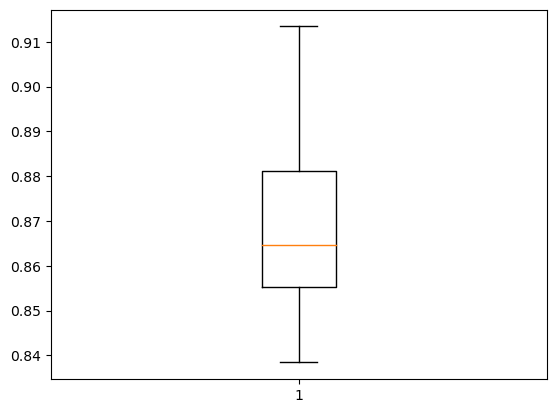

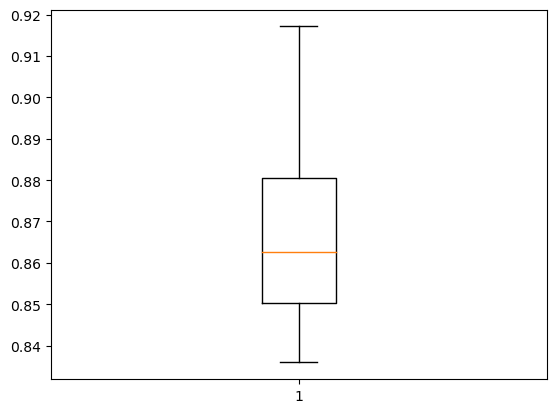

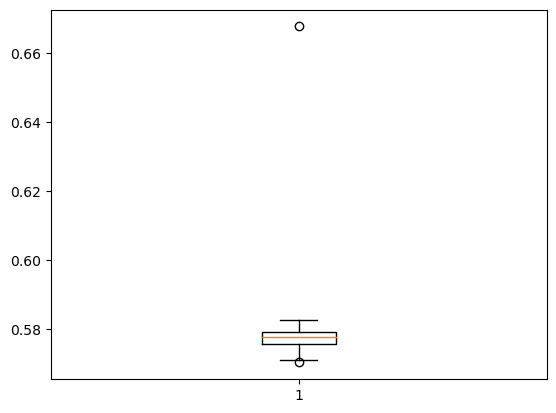

In [80]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

aucTrain_SVMSMOTELogisticRegression = list()
aucValid_SVMSMOTELogisticRegression = list()
aucFullSet_SVMSMOTELogisticRegression = list()

for i in range(1,21):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)


    SMOTE_LogitReg = Pipeline([('scaler',StandardScaler()), ('LogitRegressor',LogisticRegression(max_iter=1000))])
    SMOTE_LogitReg.fit(X_train,y_train)
    
    if i == 1:
        counter = Counter(y_resampled)
        print(counter)
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)
        
        #classificationSummary(y_train,y_pred)
        #print(metrics.classification_report(y_train,y_pred))
    if i == 1:
        y_pred = SMOTE_LogitReg.predict(X_valid)
        classificationSummary(y_valid,y_pred)
        print(metrics.classification_report(y_valid,y_pred))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_train)[::,1]
    aucTrain_SVMSMOTELogisticRegression.append(metrics.roc_auc_score(y_train, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X_valid)[::,1]
    aucValid_SVMSMOTELogisticRegression.append(metrics.roc_auc_score(y_valid, y_pred_proba))

    y_pred_proba = SMOTE_LogitReg.predict_proba(X)[::,1]
    aucFullSet_SVMSMOTELogisticRegression.append(metrics.roc_auc_score(y, y_pred_proba))

#print("Area under curve is - ", aucTrain)
#print("Area under curve is - ", aucValid)
#print("Area under curve is - ", aucFullSet)

plt.figure()
plt.boxplot(aucTrain_SVMSMOTELogisticRegression)
plt.figure()
plt.boxplot(aucValid_SVMSMOTELogisticRegression)
plt.figure()
plt.boxplot(aucFullSet_SVMSMOTELogisticRegression)

In [140]:
fp= open(r'./aucValid_SVMSMOTELogisticRegression.txt', 'w')
fp.write(str(aucValid_SVMSMOTELogisticRegression))
fp.close()

np.mean(aucValid_SVMSMOTELogisticRegression)

0.8662101205507573

## Testing with trees - SVM SMOTE sampling

In [81]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# single tree
defaultTree = DecisionTreeClassifier(random_state=1)
defaultTree.fit(X_train, y_train)
classes = defaultTree.classes_

y_pred = defaultTree.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= defaultTree.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = defaultTree.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= defaultTree.predict_proba(X)[::,1]
aucTree_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucTree_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9309)

       Prediction
Actual    0    1
     0 7864  605
     1  573 8007
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8469
           1       0.93      0.93      0.93      8580

    accuracy                           0.93     17049
   macro avg       0.93      0.93      0.93     17049
weighted avg       0.93      0.93      0.93     17049

Area under curve is -  0.9877428953146274
Confusion Matrix (Accuracy 0.9045)

       Prediction
Actual    0    1
     0 5180  559
     1  526 5102
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5739
           1       0.90      0.91      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8947)

       Prediction
Actual    0    1
     0 4955  784
     1  413 5215
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      5739
           1       0.87      0.93      0.90      5628

    accuracy                           0.89     11367
   macro avg       0.90      0.90      0.89     11367
weighted avg       0.90      0.89      0.89     11367

Area under curve is -  0.9593828829615396


{'whiskers': [<matplotlib.lines.Line2D at 0x1db00361c70>,
 'caps': [<matplotlib.lines.Line2D at 0x1db001edc40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db4dc05400>],
 'medians': [<matplotlib.lines.Line2D at 0x1db001edb80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db00365a00>],
 'means': []}

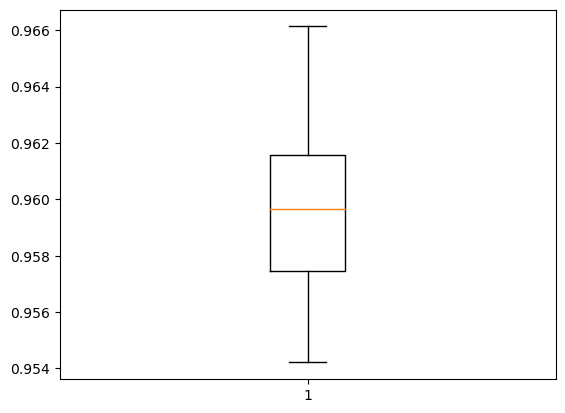

In [82]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SVMSMOTE_DefaultTree = list()

for i in range(0,21):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    defaultTree = DecisionTreeClassifier(random_state=1)
    defaultTree.fit(X_train, y_train)
    classes = defaultTree.classes_


    y_pred = defaultTree.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= defaultTree.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SVMSMOTE_DefaultTree.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SVMSMOTE_DefaultTree)    

In [141]:
fp= open(r'./aucValid_SVMSMOTE_DefaultTree.txt', 'w')
fp.write(str(aucValid_SVMSMOTE_DefaultTree))
fp.close()

np.mean(aucValid_SVMSMOTE_DefaultTree)

0.9594322880065865

In [83]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# bagging
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
classes = bagging.classes_

y_pred = bagging.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= bagging.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= bagging.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = bagging.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= bagging.predict_proba(X)[::,1]
aucBag_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBag_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9230)

       Prediction
Actual    0    1
     0 7618  851
     1  462 8118
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      8469
           1       0.91      0.95      0.93      8580

    accuracy                           0.92     17049
   macro avg       0.92      0.92      0.92     17049
weighted avg       0.92      0.92      0.92     17049

Area under curve is -  0.9831297731669677
Confusion Matrix (Accuracy 0.9007)

       Prediction
Actual    0    1
     0 5044  695
     1  434 5194
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      5739
           1       0.88      0.92      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90  

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8959)

       Prediction
Actual    0    1
     0 4991  748
     1  435 5193
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5739
           1       0.87      0.92      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90      0.90     11367

Area under curve is -  0.9715833188128012


{'whiskers': [<matplotlib.lines.Line2D at 0x1db003d48b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1db003d4e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db003d45e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1db00233430>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db00233700>],
 'means': []}

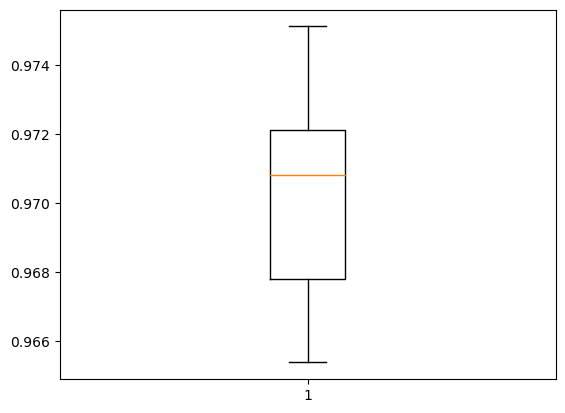

In [84]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SVMSMOTEBagging = list()

for i in range(1,21):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    bagging.fit(X_train, y_train)
    classes = bagging.classes_


    y_pred = bagging.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= bagging.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SVMSMOTEBagging.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SVMSMOTEBagging)    

In [142]:
fp= open(r'./aucValid_SVMSMOTEBagging.txt', 'w')
fp.write(str(aucValid_SVMSMOTEBagging))
fp.close()

np.mean(aucValid_SVMSMOTEBagging)

0.969855058154576

In [85]:
X = data_top10
y = data['FraudFound_P']

print("Counts before sampling - Train and validation data - ")
counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

print("Counts Train and validation data - after sampling")
counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# boosting
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
boost.fit(X_train, y_train)
classes = boost.classes_
                      
y_pred = boost.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba = boost.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= boost.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = boost.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= boost.predict_proba(X)[::,1]
aucBoost_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucBoost_undersample)

Counts before sampling - Train and validation data - 
Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counts Train and validation data - after sampling
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9338)

       Prediction
Actual    0    1
     0 7903  566
     1  562 8018
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8469
           1       0.93      0.93      0.93      8580

    accuracy                           0.93     17049
   macro avg       0.93      0.93      0.93     17049
weighted avg       0.93      0.93      0.93     17049

Area under curve is -  0.9891934963135813
Confusion Matrix (Accuracy 0.9116)

       Prediction
Actual    0    1
     0 5255  484
     1  521 5107
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      5739
           1       0.91      0.91      0.91      5628

    accuracy                           

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9000)

       Prediction
Actual    0    1
     0 5031  708
     1  429 5199
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      5739
           1       0.88      0.92      0.90      5628

    accuracy                           0.90     11367
   macro avg       0.90      0.90      0.90     11367
weighted avg       0.90      0.90      0.90     11367

Area under curve is -  0.969567116623588


{'whiskers': [<matplotlib.lines.Line2D at 0x1db001b1820>,
 'caps': [<matplotlib.lines.Line2D at 0x1db0046cd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db001b1d90>],
 'medians': [<matplotlib.lines.Line2D at 0x1db0046cd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db0046cbe0>],
 'means': []}

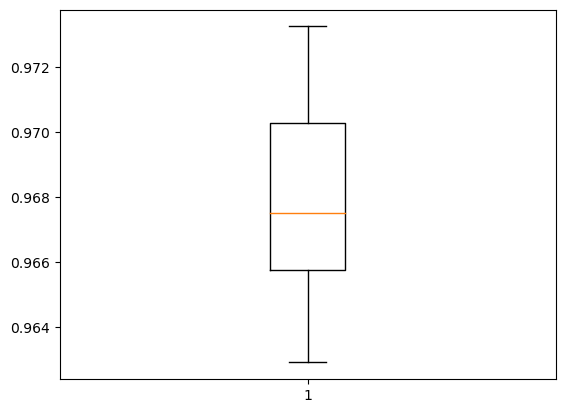

In [86]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SVMSMOTEBoost = list()

for i in range(0,21):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    # single tree
    boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
    boost.fit(X_train, y_train)
    classes = boost.classes_


    y_pred = boost.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= boost.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SVMSMOTEBoost.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SVMSMOTEBoost)    

In [143]:
fp= open(r'./aucValid_SVMSMOTEBoost.txt', 'w')
fp.write(str(aucValid_SVMSMOTEBoost))
fp.close()

np.mean(aucValid_SVMSMOTEBoost)

0.9679360564716566

## Testing with KNN - SVM SMOTE

In [87]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

k = 5
print("Value of K is - ",k)
#KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
KNN = KNeighborsClassifier(n_neighbors=k)
KNN.fit(X_train,y_train)

y_pred = KNN.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= KNN.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = KNN.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= KNN.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", auc)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Value of K is -  5


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8886)

       Prediction
Actual    0    1
     0 4964  775
     1  491 5137
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      5739
           1       0.87      0.91      0.89      5628

    accuracy                           0.89     11367
   macro avg       0.89      0.89      0.89     11367
weighted avg       0.89      0.89      0.89     11367

Area under curve is -  0.9507788949608862


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Confusion Matrix (Accuracy 0.8562)

       Prediction
Actual     0     1
     0 12468  1740
     1   431   461
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     14208
           1       0.21      0.52      0.30       892

    accuracy                           0.86     15100
   macro avg       0.59      0.70      0.61     15100
weighted avg       0.92      0.86      0.88     15100

Area under curve is -  0.8060585853861149


Counter({0: 14208, 1: 892})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})


C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Confusion Matrix (Accuracy 0.8811)

       Prediction
Actual    0    1
     0 4897  842
     1  509 5119
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5739
           1       0.86      0.91      0.88      5628

    accuracy                           0.88     11367
   macro avg       0.88      0.88      0.88     11367
weighted avg       0.88      0.88      0.88     11367



C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

Area under curve is -  0.9560957472117174


{'whiskers': [<matplotlib.lines.Line2D at 0x1db00478040>,
 'caps': [<matplotlib.lines.Line2D at 0x1db00450700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1db00450bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1db0045adf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1db0045a6d0>],
 'means': []}

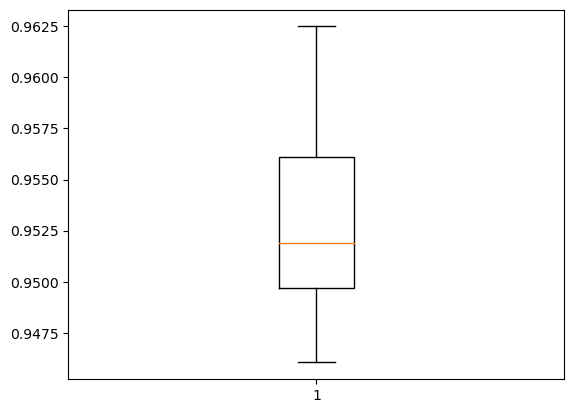

In [88]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)


aucValid_SVMSMOTEKNN = list()

for i in range(0,21):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)
    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

    if i == 1:
        counter = Counter(y_resampled)
        print(counter)

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    k = 5
    
    if k == 1:
        print("Value of K is - ",k)
    #KNN = UnderSample_LogitReg = Pipeline([('scaler',StandardScaler()), ('KNN',KNeighborsClassifier(n_neighbors=k))])
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train,y_train)
    
    y_pred = KNN.predict(X_valid)
    
    if k == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    if k == 1:
        print("Area under curve is - ", auc)


    y_pred = KNN.predict(X_valid)
    
    if i == 1:
        classificationSummary(y_valid, y_pred, class_names=classes)
        print(metrics.classification_report(y_valid,y_pred))
        
    y_pred_proba= KNN.predict_proba(X_valid)[::,1]
    auc = metrics.roc_auc_score(y_valid,y_pred_proba)
    aucValid_SVMSMOTEKNN.append(auc)

print("Area under curve is - ", auc)

plt.figure()
plt.boxplot(aucValid_SVMSMOTEKNN)    

In [144]:
fp= open(r'./aucValid_SVMSMOTEKNN.txt', 'w')
fp.write(str(aucValid_SVMSMOTEKNN))
fp.close()

np.mean(aucValid_SVMSMOTEKNN)

0.9532560411118853

## SVM with SVM SMOTE

In [89]:
X = data_top10
y = data['FraudFound_P']

counter = Counter(y)
print(counter)

over = SVMSMOTE()
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
SMOTESampling = SamplingPipeline(steps=steps)

X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_resampled)
print(counter)

X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

counter = Counter(y_train)
print(counter)
counter = Counter(y_valid)
print(counter)

# SVM
SVM = svm.SVC(probability=True)
SVM.fit(X_train, y_train)
classes = defaultTree.classes_
                      
y_pred = SVM.predict(X_train)
classificationSummary(y_train, y_pred, class_names=classes)
print(metrics.classification_report(y_train,y_pred))
y_pred_proba= SVM.predict_proba(X_train)[::,1]
auc = metrics.roc_auc_score(y_train,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X_valid)
classificationSummary(y_valid, y_pred, class_names=classes)
print(metrics.classification_report(y_valid,y_pred))
y_pred_proba= SVM.predict_proba(X_valid)[::,1]
auc = metrics.roc_auc_score(y_valid,y_pred_proba)
print("Area under curve is - ", auc)

y_pred = SVM.predict(X)
classificationSummary(y, y_pred, class_names=classes)
print(metrics.classification_report(y,y_pred))
y_pred_proba= SVM.predict_proba(X)[::,1]
aucSVM_undersample = metrics.roc_auc_score(y,y_pred_proba)
print("Area under curve is - ", aucSVM_undersample)

Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.9023)

       Prediction
Actual    0    1
     0 8469    0
     1 1665 6915
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8469
           1       1.00      0.81      0.89      8580

    accuracy                           0.90     17049
   macro avg       0.92      0.90      0.90     17049
weighted avg       0.92      0.90      0.90     17049

Area under curve is -  0.9264879991500607
Confusion Matrix (Accuracy 0.9048)

       Prediction
Actual    0    1
     0 5739    0
     1 1082 4546
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5739
           1       1.00      0.81      0.89      5628

    accuracy                           0.90     11367
   macro avg       0.92      0.90      0.90     11367
weighted avg       0.92      0.90  

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Area under curve is -  0.6481813362900455


Counter({0: 14208, 1: 892})
Counter({0: 14208, 1: 14208})
Counter({1: 8580, 0: 8469})
Counter({0: 5739, 1: 5628})
Confusion Matrix (Accuracy 0.8065)

       Prediction
Actual    0    1
     0 5739    0
     1 2199 3429
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      5739
           1       1.00      0.61      0.76      5628

    accuracy                           0.81     11367
   macro avg       0.86      0.80      0.80     11367
weighted avg       0.86      0.81      0.80     11367

Area under curve is -  0.8940810936728499


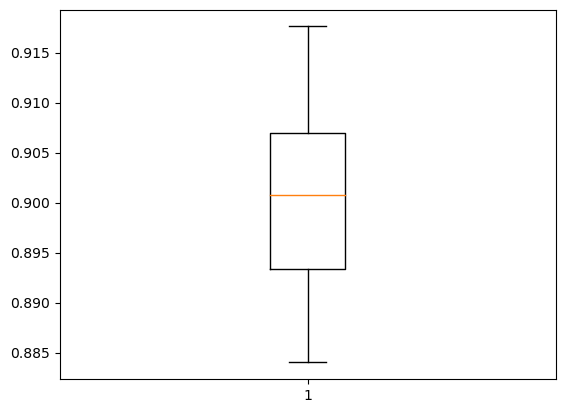

In [91]:
if RunSVM:    
    X = data_top10
    y = data['FraudFound_P']

    counter = Counter(y)
    print(counter)

    aucSVM_SVMSMOTE = list()

    for i in range(1,21):
        over = SVMSMOTE(random_state=i)
        under = RandomUnderSampler(sampling_strategy=1)
        steps = [('o', over), ('u', under)]
        SMOTESampling = SamplingPipeline(steps=steps)
        X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)

        if i == 1:
            counter = Counter(y_resampled)
            print(counter)

        X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

        if i == 1:
            counter = Counter(y_train)
            print(counter)
            counter = Counter(y_valid)
            print(counter)

        # SVM
        SVM = svm.SVC(probability=True)
        SVM.fit(X_train, y_train)
        classes = SVM.classes_


        y_pred = SVM.predict(X_valid)

        if i == 1:
            classificationSummary(y_valid, y_pred, class_names=classes)

        if i == 1:
            print(metrics.classification_report(y_valid,y_pred))

        y_pred_proba = SVM.predict_proba(X_valid)[::,1]
        auc = metrics.roc_auc_score(y_valid,y_pred_proba)
        aucSVM_SVMSMOTE.append(auc)

        if i == 1:
            print("Area under curve is - ", auc)

    plt.figure()
    plt.boxplot(aucSVM_SVMSMOTE)  

In [145]:
fp= open(r'./aucSVM_SVMSMOTE.txt', 'w')
fp.write(str(aucSVM_SVMSMOTE))
fp.close()

np.mean(aucSVM_SVMSMOTE)

0.9000226461474522